## Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## NeRF Network Architecture

In [2]:
class NeRF(torch.nn.Module):
    def __init__(self, positional_encoding_pos=10, positional_encoding_dir=4, hidden_dim=256):
        super(NeRF, self).__init__()

        self.positional_encoding_pos = positional_encoding_pos
        self.positional_encoding_dir = positional_encoding_dir

        self.block1 = torch.nn.Sequential(
            nn.Linear(in_features=positional_encoding_pos * 6,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU()
        )

        self.block2 = torch.nn.Sequential(
            nn.Linear(in_features=hidden_dim + positional_encoding_pos * 6,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim + 1)
        )

        self.block3 = torch.nn.Sequential(
            nn.Linear(in_features=hidden_dim + positional_encoding_dir * 6,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=3),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU()

    def positional_encoding(self, x, L):
        out = []
        for i in range(L):
            out.append(torch.sin(2 ** i * torch.pi * x))
            out.append(torch.cos(2 ** i * torch.pi * x))
        return torch.cat(out, dim=-1)

    def forward(self, pos, dir):
        pos_encoded = self.positional_encoding(pos, self.positional_encoding_pos)
        dir_encoded = self.positional_encoding(dir, self.positional_encoding_dir)
        x = self.block1(pos_encoded)
        x = self.block2(torch.cat((x, pos_encoded), dim=-1))
        sigma = self.relu(x[:, -1])
        color = self.block3(torch.cat((x[:, :-1], dir_encoded), dim=-1))
        return color, sigma

## Rendering Functions

In [6]:
def calculate_T(sigdel_exp):
    T = torch.cumprod(sigdel_exp, dim=1)
    T = torch.concat((torch.ones((T.shape[0], 1)).to(T.device), T[:, :-1]), dim=1)
    return T

In [7]:
def calculate_C(T, alphas, colors):
    weights = T * alphas
    weights = weights.unsqueeze(2)
    C = (weights * colors).sum(1)
    return C

In [18]:
def create_t_samples(hn, hf, n_bins, n_rays, device):
    t = torch.linspace(hn, hf, n_bins+1, device=device).expand(n_rays, n_bins+1)
    u = torch.rand(t.shape, device=device)
    t = t + (u * ((hf-hn) / n_bins))
    return t[:, :-1]

In [9]:
def create_ray_points(ray_origins, ray_directions, t):
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)
    return x

In [23]:
def nerf_render(model, ray_origins, ray_directions, hn=0.0, hf=0.5, n_bins=192):
    t = create_t_samples(hn=hn, hf=hf, n_bins=n_bins, n_rays=ray_origins.shape[0], device=ray_origins.device)
    query_points = create_ray_points(ray_origins, ray_directions, t) # [batch_size, n_bins, 3]
    query_points = query_points.reshape((-1, 3)) # reshape for network
    query_directions = ray_directions.expand(n_bins, ray_directions.shape[0], 3).transpose(0, 1) # [batch_size, n_bins, 3]
    query_directions = query_directions.reshape((-1, 3)) # reshape for network
    
    colors, sigmas = model(query_points, query_directions)
    colors = colors.reshape(t.shape[0], t.shape[1], 3)
    sigmas = sigmas.reshape(t.shape[0], t.shape[1])
    deltas = torch.cat((t[:, 1:] - t[:, :-1],
                        torch.tensor([1e10]).expand(t.shape[0], 1).to(ray_origins.device)), dim=1)
    sigdel_exp = torch.exp(- sigmas * deltas)
    
    T = calculate_T(sigdel_exp)
    pixel_values = calculate_C(T, 1 - sigdel_exp, colors)
    return pixel_values

## Loading Dataset

In [10]:
training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))

In [11]:
training_dataset.shape # 100 RGB images of size 400x400

torch.Size([16000000, 9])

In [12]:
sample_image = training_dataset[:160_000, :] # first image's rays (160_000 per view)

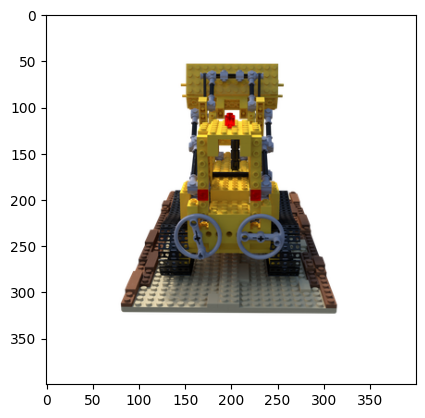

In [13]:
plt.imshow(sample_image[:, 6:].reshape((400, 400, 3)).numpy())

## Training On a Single View

In [29]:
@torch.no_grad()
def inference(model, ray_origins, ray_directions, batch_size=512, device='cpu', hn=0.0, hf=1.0, n_bins=192):
    data = []  # list of regenerated pixel values
    
    for i in range(int(np.ceil(ray_origins.shape[0] / batch_size))):
        ray_origins_batch = ray_origins[i * batch_size: (i + 1) * batch_size].to(device)
        ray_directions_batch = ray_directions[i * batch_size: (i + 1) * batch_size].to(device)        
        pred_pixel_values = nerf_render(
                model, ray_origins_batch, ray_directions_batch, hn=hn, hf=hf, n_bins=n_bins)
        data.append(pred_pixel_values)
    
    image = torch.cat(data).data.cpu().numpy().reshape(400, 400, 3)
    return image

In [24]:
def train(model, dataloader, optimizer, device='cpu', hn=0.0, hf=1.0, n_bins=192, n_epochs=10):

    loss_fn = nn.MSELoss()

    for e in range(n_epochs):
        epoch_mean_loss = 0.0
        for batch in dataloader:
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            gt_pixel_values = batch[:, 6:].to(device)

            pred_pixel_values = nerf_render(
                model, ray_origins, ray_directions, hn=hn, hf=hf, n_bins=n_bins)
            
            loss = loss_fn(pred_pixel_values, gt_pixel_values)
            epoch_mean_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_mean_loss /= len(dataloader)
        print(f'EPOCH {e}: Loss= {epoch_mean_loss:.4f}')

In [27]:
device = torch.device('cuda')
model = NeRF().to(device)
dataloader = torch.utils.data.DataLoader(training_dataset[:160000], batch_size=512, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [33]:
train(model, dataloader, optimizer, device=device, hn=2, hf=6, n_bins=192, n_epochs=5)

EPOCH 0: Loss= 0.0016
EPOCH 1: Loss= 0.0014
EPOCH 2: Loss= 0.0014
EPOCH 3: Loss= 0.0012
EPOCH 4: Loss= 0.0012


In [34]:
image = inference(model, training_dataset[:160000, :3], training_dataset[:160000, 3:6],
          device=device, hn=2, hf=6, n_bins=192)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


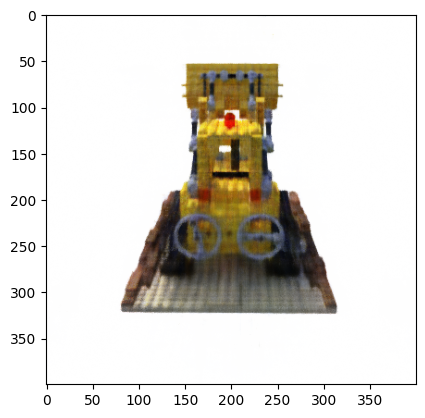

In [35]:
plt.imshow(image)